# Class 03 - Supplemental
## Using Categorical data in machine learning

Now that we've created some categorical data or other created features, we would like to use them as inputs for our machine learning algorithm. However, we need to tell the computer that the categorical data isn't the same as other numerical data. For example, I could have the following two types of categorical data:

1. Ordered Categorical Data: items like rankings or scales where the size of the output corresponds to some placement along a line. One example is the grade scale where A=4, B=3, C=2, D=1, F=0.
2. Unordered Categorical Data: Categories like gender, race, state, or color don't have any rational scale to place them on. So assigning red=4, blue=3 doesn't mean red is 'better' than blue.

We want to treat both of these slightly differently. We've got a sample dataset with both types of categorical data in it to work with. Our goal will be to predict the Output value.

In [1]:
sampledata <- read.csv('Class03_supplemental_data.csv', stringsAsFactors=FALSE)

print(str(sampledata))
head(sampledata)

'data.frame':	1000 obs. of  4 variables:
 $ Date  : chr  "2004-03-15T12:45:32Z" "2004-03-15T20:50:02Z" "2004-03-16T05:46:43Z" "2004-03-16T22:19:24Z" ...
 $ Rank  : chr  "E" "F" "E" "D" ...
 $ State : chr  "NH" "MO" "MT" "LA" ...
 $ Output: num  212 210 211 209 206 ...
NULL


Date,Rank,State,Output
2004-03-15T12:45:32Z,E,NH,211.8134
2004-03-15T20:50:02Z,F,MO,210.2189
2004-03-16T05:46:43Z,E,MT,210.9158
2004-03-16T22:19:24Z,D,LA,209.3553
2004-03-17T05:01:51Z,D,MD,205.6534
2004-03-17T13:41:21Z,E,ME,209.5376


We can turn the date column into a real datetime object and get days since the first day in order to work with a more reasonable set of values.

In [2]:
sampledata$Date2 <- as.POSIXct(sampledata$Date)
firstdate <- head(sampledata$Date2,1)

sampledata$DaysSinceStart <- as.numeric(difftime(sampledata$Date2, firstdate, units = "hours")/24)
str(sampledata)

'data.frame':	1000 obs. of  6 variables:
 $ Date          : chr  "2004-03-15T12:45:32Z" "2004-03-15T20:50:02Z" "2004-03-16T05:46:43Z" "2004-03-16T22:19:24Z" ...
 $ Rank          : chr  "E" "F" "E" "D" ...
 $ State         : chr  "NH" "MO" "MT" "LA" ...
 $ Output        : num  212 210 211 209 206 ...
 $ Date2         : POSIXct, format: "2004-03-15" "2004-03-15" ...
 $ DaysSinceStart: num  0 0 1 1 2 2 3 3 4 4 ...


## Ordered Categorical Values

The 'Rank' column are ranked categorical values where the ranking matters on a linear scale. So we can create a categorical column for these values right away. We are lucky here that the values are in alphabetical order - R picks up that order for us.

In [3]:
sampledata$CatRank <- factor(sampledata$Rank, ordered=TRUE)
print(sampledata$CatRank[1:10])
print(as.numeric(sampledata$CatRank[1:10]))

 [1] E F E D D E C B B C
Levels: A < B < C < D < E < F
 [1] 5 6 5 4 4 5 3 2 2 3


## Unordered Categorical Values

Let's now put the states into a categorical column. Even though R will sort them, there is no real 'rank' for the states

In [4]:
sampledata$CatState <- factor(sampledata$State)
print(sampledata$CatState[1:10])
print(as.numeric(sampledata$CatState[1:10]))

 [1] NH MO MT LA MD ME KY MO VT RI
50 Levels: AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ... WY
 [1] 30 24 26 18 20 21 17 24 46 39


## Modeling with Categorical Data

Let's split the dataset and try modeling - we want to predict the output value. We need the categorical codes as columns to do this, so we'll take care of that part first.

In [5]:
sampledata$RankCode <- as.numeric(sampledata$CatRank)
sampledata$StateCode <- as.numeric(sampledata$CatState)
names(sampledata)

[1] "Date"           "Rank"           "State"          "Output"        
 [5] "Date2"          "DaysSinceStart" "CatRank"        "CatState"      
 [9] "RankCode"       "StateCode"

In [6]:
set.seed(23)

trainIndex <- sample(seq(nrow(sampledata)), nrow(sampledata)*0.8)

train1 <- sampledata[trainIndex, ]
test1 <- sampledata[-trainIndex, ]

# Step 2: Create linear regression object
inputcolumns <- c('DaysSinceStart', 'RankCode','StateCode')
lmformula <- as.formula(paste('Output ~',paste(inputcolumns, collapse='+')))

# Step 2: Fit the model
regr1 <- lm(lmformula, train1)

[1] "RMS Error: 3.52302610126192"


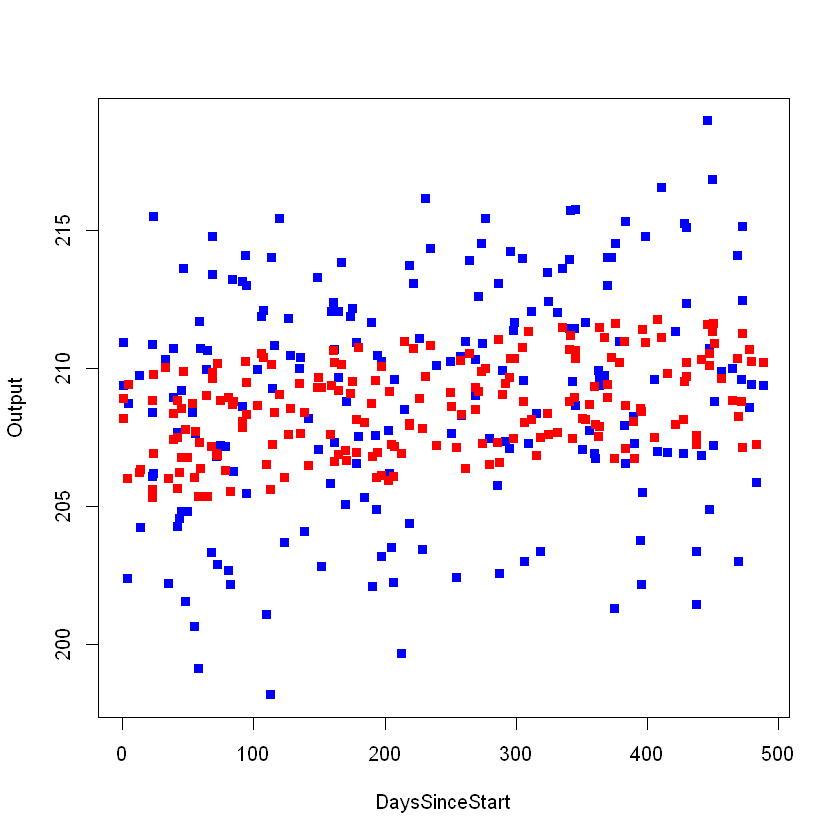

In [7]:
# Step 3: Get the predictions
predictions <- predict(regr1,test1)
actuals <- test1$Output

# Step 4: Plot the results
plot(test1$DaysSinceStart,actuals, pch=15, col="blue", xlab="DaysSinceStart",  ylab="Output")

points(test1$DaysSinceStart,predictions, pch=15, col="red", xlab="DaysSinceStart",  ylab="Output")

# Add a legend
legend(0,2.4, # places a legend at the appropriate place
       c("Actuals","Predictions"), # puts text in the legend
       pch=c(15,15), # Sets the symbol correctly for the point and line
       col=c("blue","red")) # gives the legend lines the correct color and width

# Step 7: Get the RMS value
print(paste("RMS Error:",sqrt(mean((predictions-actuals)^2))))

So we see that this didn't do a very good job to start with. However, that's not surprising as it used the states as a ranked categorical value when they obviously aren't.


## Using Unranked categorical values

What we want is called a **dummy variable**. It will tell the machine learning algorithm to look at whether an entry is one of the states or not. Here's basically how it works. Suppose we have two categories: red and blue. Our categorical column may look like this:

| Row | Color |
|--- |---|
|0 | red |
| 1 | red |
| 2 | blue |
|3 | red |

What we want are two new columns that identify whether the row belongs in one of the categories. We'll use `1` when it belongs and `0` when it doesn't. This is what we get:

| Row | IsRed | IsBlue |
| --- | --- | ---|
| 0 | 1 | 0 |
| 1 | 1 | 0 |
| 2 | 0 | 1 | 
| 3 | 1 | 0 |


We now use these new dummy variable columns as the inputs: they are binary and will only have a 1 value where the original row matched up with the category column. We will use the `mlr` library that has this functionality built in.


In [8]:
library(mlr)
dummydf <- createDummyFeatures(sampledata$CatState)
colnames(dummydf) <- paste("S", colnames(dummydf), sep = "_")
head(dummydf)

Warning message:
"package 'mlr' was built under R version 3.3.3"Loading required package: ParamHelpers
Warning message:
"package 'ParamHelpers' was built under R version 3.3.3"

S_AK,S_AL,S_AR,S_AZ,S_CA,S_CO,S_CT,S_DE,S_FL,S_GA,...,S_SD,S_TN,S_TX,S_UT,S_VA,S_VT,S_WA,S_WI,S_WV,S_WY
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now want to join this back with the original set of features so that we can use it instead of the ranked column of data. Here's one way to do that.

In [9]:
sampledata2 <- cbind(sampledata,dummydf)
head(sampledata2)

Date,Rank,State,Output,Date2,DaysSinceStart,CatRank,CatState,RankCode,StateCode,...,S_SD,S_TN,S_TX,S_UT,S_VA,S_VT,S_WA,S_WI,S_WV,S_WY
2004-03-15T12:45:32Z,E,NH,211.8134,2004-03-15,0,E,NH,5,30,...,0,0,0,0,0,0,0,0,0,0
2004-03-15T20:50:02Z,F,MO,210.2189,2004-03-15,0,F,MO,6,24,...,0,0,0,0,0,0,0,0,0,0
2004-03-16T05:46:43Z,E,MT,210.9158,2004-03-16,1,E,MT,5,26,...,0,0,0,0,0,0,0,0,0,0
2004-03-16T22:19:24Z,D,LA,209.3553,2004-03-16,1,D,LA,4,18,...,0,0,0,0,0,0,0,0,0,0
2004-03-17T05:01:51Z,D,MD,205.6534,2004-03-17,2,D,MD,4,20,...,0,0,0,0,0,0,0,0,0,0
2004-03-17T13:41:21Z,E,ME,209.5376,2004-03-17,2,E,ME,5,21,...,0,0,0,0,0,0,0,0,0,0


We now want to select out all 50 columns from the dummy variable. There is a python way to do this easily, since we used the prefix 'S\_' for each of those columns 

In [10]:
inputcolumns2 <- c('DaysSinceStart','RankCode',  grep("S_",colnames(sampledata2),value=TRUE))

trainIndex2 <- sample(seq(nrow(sampledata2)), nrow(sampledata2)*0.8)

train2 <- sampledata2[trainIndex2, ]
test2 <- sampledata2[-trainIndex2, ]

lmformula2 <- as.formula(paste('Output ~',paste(inputcolumns2, collapse='+')))

# Step 2: Fit the model
regr2 <- lm(lmformula2, train2)

Warning message in predict.lm(regr2, test2):
"prediction from a rank-deficient fit may be misleading"

[1] "RMS Error: 1.23632439746239"


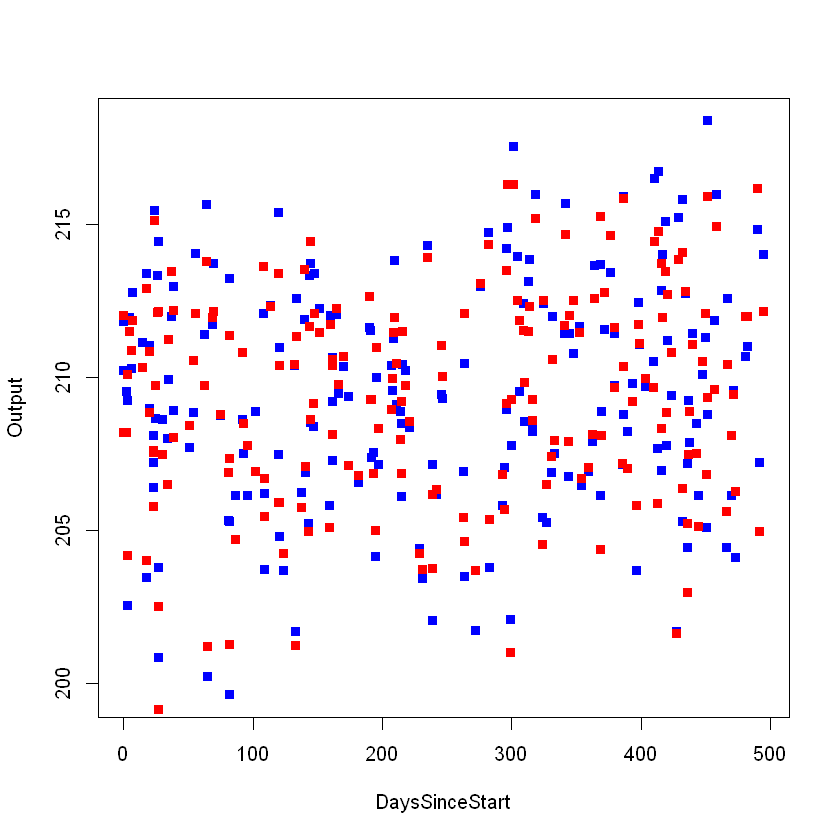

In [11]:
# Step 3: Get the predictions
predictions <- predict(regr2,test2)
actuals <- test2$Output

# Step 4: Plot the results
plot(test2$DaysSinceStart,actuals, pch=15, col="blue", xlab="DaysSinceStart",  ylab="Output")

points(test2$DaysSinceStart,predictions, pch=15, col="red", xlab="DaysSinceStart",  ylab="Output")

# Add a legend
legend(0,2.4, # places a legend at the appropriate place
       c("Actuals","Predictions"), # puts text in the legend
       pch=c(15,15), # Sets the symbol correctly for the point and line
       col=c("blue","red")) # gives the legend lines the correct color and width

# Step 7: Get the RMS value
print(paste("RMS Error:",sqrt(mean((predictions-actuals)^2))))

So, you can see we did significantly better by changing the categorical column into a dummy variable. Take a look at your own datasets to see if this is what you should be doing.